# Como buscar en el mapa de la simulación

Este corto notebook explica como buscar en el mapa de la simulación

### Creando el mapa

Ahora creemos un nuevo mapa. Pero antes de esto debemos crear un nuevo conjunto de puntos. Para esto usaremos la clase ``

40


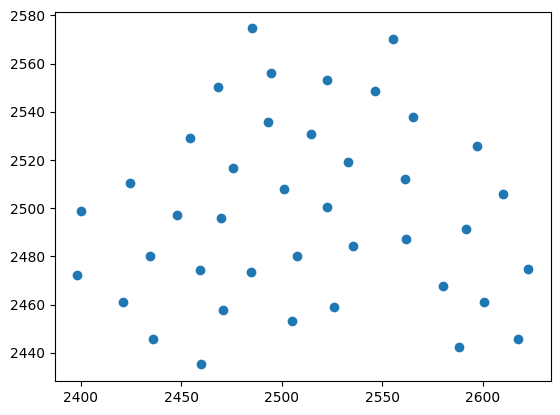

In [75]:
from supply_chain.products.specific_products.base_products.pizza_base_products import PizzaDough
from utils.points_generators import poisson_disc_sampling
import matplotlib.pyplot as plt
import random as rnd

points = poisson_disc_sampling(10 + 5 + 5 + 20, (0, 0), (5000, 5000), 20, 20)
plt.scatter([p[0] for p in points], [p[1] for p in points])
print(len(points))



In [76]:
def plot_map(
        points: tuple[float, float],
        connections: list[tuple[tuple[float, float], tuple[float, float]]],
        path: tuple[list[float], list[float]] = None,
):
    plt.scatter([p[0] for p in points], [p[1] for p in points])
    for p1, p2 in connections:
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="grey")
    if path is not None:
        plt.plot(path[0], path[1], color="green")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Plot of Points and Connections")
    plt.grid(True)
    plt.show()

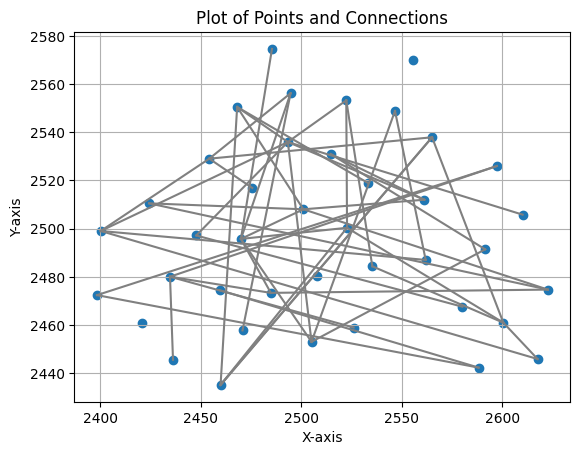

In [77]:
from sim_map import SimMap, MapNode

# Now let's create some connections

number_of_connections = 50
connections: list[tuple[tuple[float, float], tuple[float, float]]] = []

simulation_map: SimMap = SimMap()

for _ in range(number_of_connections):
    p1, p2 = rnd.sample(points, 2)
    connections.append((p1, p2))
    simulation_map.add_bidirectional_connection_with_random_distance(p1, p2, 50, True)

plot_map(points, connections, None)


## Buscando en el mapa

Ahora que tenemos un mapa creado solo hace falta buscar en este

A path was found
(2597.2950618436957, 2525.964486843763)
(2434.703374635157, 2480.0342555042907)
(2484.852396889454, 2473.323244004377)
(2469.9773065840122, 2495.7158968479644)
(2522.76411935235, 2500.3408975075095)
(2522.3766171815196, 2553.2237327997946)


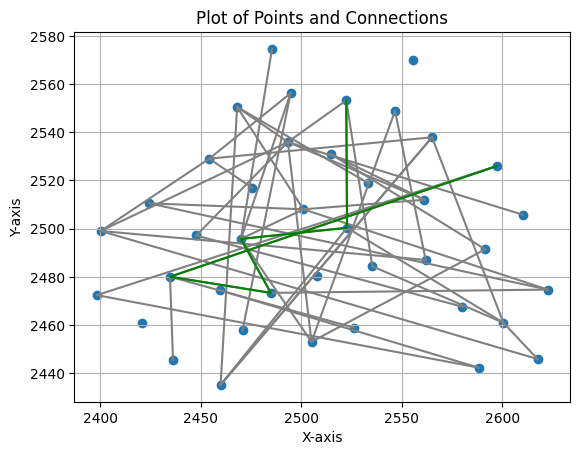

The distance is 458.342516


In [78]:
from map_search_problem import MapSearchProblem
from sim_ai.search_problem.search_algorithms import *
from utils.utility_functions import distance_between_points


def map_heuristic(
        actual_position: tuple[float, float], final_position: tuple[float, float]
) -> float:
    return distance_between_points(actual_position, final_position)


def path(node: SearchNode) -> tuple[list[float], list[float]]:
    result = node.get_path()
    x_coordinates = [p[0] for p in result]
    y_coordinates = [p[1] for p in result]
    return (x_coordinates, y_coordinates)


initial_position, final_position = rnd.sample(points, 2)

map_problem = MapSearchProblem(
    initial_position=initial_position,
    final_position=final_position,
    city_map=simulation_map,
)
found, final_node = a_star_search(
    map_problem, lambda node: map_heuristic(node.state, final_position)
)

if found:
    print(f"A path was found")
    original_path = final_node.get_path()
    for state in original_path:
        print(state)
    plot_map(points, connections, path(final_node))
    print(f"The distance is {final_node.path_cost:2f}")
    # plt.show()
else:
    print("A path was not found")

## Como entran las empresas en este mapa

Simple, el mapa es un mapa de puntos y las empresas tienen una propiedad llamada `position_in_map` que dice en que punto del mapa se encuentran.
Para que el **Agente Logístico** diga un precio por su transportación, primero debe computar la distancia entre el punto de salida y el punto de llegada usando la búsqueda anteriormente implementada, luego decide el precio y el tiempo que se demorará en llegar en base a la distancia y la cantidad de unidades a transportar.
> Nota: El tiempo de llegada del transportista es dependiendo de la velocidad de su equipo de transportación. Cada transportista tiene una propiedad que dice su velocidad. Pero el tiempo de llegada real depende de una variable aleatoria que dice como se comporta su retraso.

In [79]:
from supply_chain.sim_environment import SimEnvironment


In [80]:
from supply_chain.simulation import SupplyChainSimulator

In [81]:

environment = SimEnvironment(simulation_map)

simulator = SupplyChainSimulator(environment, 60 * 60 * 24 * 7)


Lambda para dar el tiempo

In [82]:
get_time = environment.get_time

In [83]:
add_event = simulator.add_event

Lambda para enviar mensaje

In [84]:
send_msg = environment.send_message

## Creación de las empresas de la compañía

Creemos entonces algunas compañías para la simulación


Crear el stock manager

In [85]:
from supply_chain.Company.stock_manager.productor_stock_manager import *

In [86]:
def create_product(count=1):
    lis = []
    for _ in range(0, count):
        lis.append(PizzaDough(10))

    return lis





In [87]:
products_names = ["Pizza"]
create_product_lambda = {}
create_product_lambda[products_names[0]] = create_product

In [88]:
from supply_chain.Building.build_stock_manager import BuildProductorStockManager
from supply_chain.Company.companies_types.Producer_Company import *

stock_manager_1 = BuildProductorStockManager(add_event=add_event,
                                             get_time=get_time,
                                             create_product_lambda=create_product_lambda,
                                             list_products_can_sell_name=products_names
                                             ).create_ProductorStockManager()



In [89]:
from supply_chain.Company.stock_manager import stock_manager

producer_1 = ProducerCompany("Empresa_1", get_time, add_event, stock_manager_1)
producer_1.start()

# Crear el visualizador para el agente

## Crear los hechos del inferenciador

In [90]:
def get_dict_valoracion_inicial() -> dict[TypeCompany, dict[str, float]]:
    dict_return = {}
    dict_2 = {"MAtrix_1": 7}
    dict_return[TypeCompany.Matrix] = dict_2
    return dict_return

In [91]:
from supply_chain.agents.utils import *


def  get_logic_implication () -> list[ImplicationLogicWrapped]:

    cliente_x = ClientWrapped('x')  #Cliente(x)
    valoracion_x_bien = Valoracion("x", ValoracionTag.Bien)  #Valoracion_(x,Bien)
    
    product_y = ProductWrapped('y')  #Product_(y)
    
    
    
    pedir_precio_hecho = PedirPrecio('x', 'y', NumberWrapped(1))  #Pedir_precio(x,y,1) persona # # producto factor=1
    
    pedir_cant_suplir_hecho = PedirCantidad('x', 'y', NumberWrapped(1))
    left_part = AndLogicWrapped(
        [cliente_x, valoracion_x_bien, product_y])
    implication_ = ImplicationLogicWrapped(
        [left_part], [pedir_precio_hecho]
    )
    
    implication_pedir_cant_suplir = ImplicationLogicWrapped(
        [left_part], [pedir_cant_suplir_hecho]
    )
    return [implication_, implication_pedir_cant_suplir]
    

In [92]:
cliente_x = ClientWrapped('x')  #Cliente(x)
valoracion_x_bien = Valoracion("x", ValoracionTag.Bien)  #Valoracion_(x,Bien)

product_y = ProductWrapped('y')  #Product_(y)



pedir_precio_hecho = PedirPrecio('x', 'y', NumberWrapped(1))  #Pedir_precio(x,y,1) persona # # producto factor=1


left_part = AndLogicWrapped(
    [cliente_x, valoracion_x_bien, product_y])
implication_ = ImplicationLogicWrapped(
    [left_part], [pedir_precio_hecho]
)
print(implication_.show())

 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_precio(x,y,Float_1)  


In [93]:
from supply_chain.agents.enviroment_visulizer import EnvVisualizer

env = EnvVisualizer(get_time,
                    send_msg,
                    get_dict_valoracion_inicial,
                    get_logic_implication,
                    None
                    )

In [94]:
from supply_chain.agents.Producer_Agent import ProducerAgent

agent_producer_1 = ProducerAgent("Empresa_1",
                                 producer_1,
                                 env

                                 )

Product(Pizza)
Valoracion_(MAtrix_1,Bien)
 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_precio(x,y,Float_1)  
 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_cantidad(x,y,Float_1)  
Product(Pizza)
Valoracion_(MAtrix_1,Bien)
 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_precio(x,y,Float_1)  
 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_cantidad(x,y,Float_1)  


In [95]:
from supply_chain.Mensajes.ask_msg import MessageWantProductOffer

ask_pizza_to_producto_1 = MessageWantProductOffer(
    company_from="MAtrix_1",
    company_from_type=TypeCompany.Matrix,
    company_destination_name=producer_1.name,
    company_destination_type=producer_1.tag,
    product_want_name=products_names[0]

)

In [96]:
agent_producer_1.recive_msg(ask_pizza_to_producto_1)

Product(Pizza)
Valoracion_(MAtrix_1,Bien)
 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_precio(x,y,Float_1)  
 ( Client(x) &   Valoracion_(x,Bien) &   Product(y))   ==>  Pedir_cantidad(x,y,Float_1)  
Pedir_precio(MAtrix_1,Pizza,z)
Pedir_cantidad(MAtrix_1,Pizza,z)
Factor de venta 1.0
Producto: Pizza precio por unidad 20.1 cuanto puede suplir 300 el id 739e9839-d460-40bb-8177-6853dcc1a540 y finaliza en el 3000009


Exception: There is no company in map with name

None
